Group 2

Abd-Elgwad, Ahmed 300389361

Abdullah, Alaa 300389374

Sorror, Omnia 300389912

Ahmed, Esraa 300389886

Mashaal, Rowan 300389920

importing libraries needed in our project

In [1]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import cv2
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Your code generating warnings goes here
# ...

# Reset warnings to default behavior (optional)
warnings.resetwarnings()

# For some reason we seem to need to load tf onto the GPU first
dummy = tf.constant( 32 )
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

C:\Users\project\anaconda3\envs\ML\lib\site-packages\google\auth\__init__.py:55: Python37DeprecationWarning: After January 1, 2024, new releases of this library will drop support for Python 3.7. More details about Python 3.7 support can be found at https://cloud.google.com/python/docs/python37-sunset/
  warnings.warn(message, Python37DeprecationWarning)
C:\Users\project\anaconda3\envs\ML\lib\site-packages\google\oauth2\__init__.py:40: Python37DeprecationWarning: After January 1, 2024, new releases of this library will drop support for Python 3.7. More details about Python 3.7 support can be found at https://cloud.google.com/python/docs/python37-sunset/
  warnings.warn(message, Python37DeprecationWarning)
C:\Users\project\anaconda3\envs\ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Num GPUs Available:  1


## Installing TensorFlow Datasets

In [2]:
!pip install tensorflow-datasets

sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1b7984ff128>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1b7984ff2e8>
C:\Users\project\anaconda3\envs\ML\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedWriter name=4>
  return process_handler(cmd, _system_body)
C:\Users\project\anaconda3\envs\ML\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedReader name=5>
  return process_handler(cmd, _system_body)
C:\Users\project\anaconda3\envs\ML\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  return process_handler(cmd, _system_body)


# Setting our dataset directory and reding them

In [3]:
tfds.disable_progress_bar()
PROJECT_ROOT_DIR = 'C:/Users/project/Downloads/project'
data_path = os.path.join(PROJECT_ROOT_DIR, 'tensorflow_data')
os.makedirs(data_path, exist_ok = True)

print("Using directory: ", data_path)

Using directory:  C:/Users/project/Downloads/project\tensorflow_data


# Data Preprocessing 

The function load_all_videos iterates through the provided dataset and gathers all the videos it contains into a list (all_videos). The provided code uses this function to load videos from three different datasets (fixed_data, linear_data, and rotated_data) obtained using tfds.load for subsequent processing or analysis.

In [4]:
def load_all_videos(dataset):
    iter_data = iter(dataset['train'])
    all_videos = []
    try:
        while True:
            video = next(iter_data)
            all_videos.append(video)
    except StopIteration:
        pass
    return all_videos

fixed_data = tfds.load('elg7186_projectdata/fixed_random_rotate', data_dir=data_path)
linear_data = tfds.load('elg7186_projectdata/linear_movement_rotate', data_dir=data_path)
rotated_data = tfds.load('elg7186_projectdata/rotation_rotate', data_dir=data_path)

first_video = load_all_videos(fixed_data)
second_video = load_all_videos(linear_data)
third_video = load_all_videos(rotated_data)

In [5]:
def find_index(input, id):
    for i in range(len(input)):
        if input[i] == id:
            return i
            break

This function process_videos performs a series of preprocessing steps on a collection of videos extracted from a dataset. Here's an overview of the preprocessing steps:

    Extracting Video Metadata:
        Retrieves metadata such as the number of frames, resolution (height and width), and video name from each video in the dataset.

    Looping Through Frames:
        Iterates through each frame within the videos.
        Extracts the image data for each frame and appends it to the images_list.
        Creates unique image names for each frame based on the video name and frame number.

    Bounding Box Processing:
        Extracts bounding box information for each frame within the videos.
        Processes bounding box data and calculates:
            x_center and y_center coordinates.
            width and height of the bounding boxes.
        Stores this processed bounding box information in the frame_bboxes list and the corresponding class IDs in the frame_classes list.

    Constructing DataFrame:
        Constructs a Pandas DataFrame (df) containing the following columns:
            'image': Contains image data for each frame.
            'image_name': Contains unique names for each frame derived from the video name and frame number.
            'bounding_boxes': Contains processed bounding box coordinates for each frame.
            'classes': Contains class IDs for objects detected in each frame

In [6]:

def process_videos(all_videos):
    images_list = []
    bboxes_list = []
    classes_list = []
    image_names = []  # New list for image names

    for train_data in all_videos:
        num_frames = int(train_data['metadata']['num_frames'])
        resolution = [train_data['metadata']['height'], train_data['metadata']['width']]
        video_name = train_data['metadata']['video_name']  # Assuming image names are stored in 'video_name' field

        for i in range(num_frames):
            image = train_data['video'][i, :, :, :].numpy()
            images_list.append(image)
            image_names.append(f"{video_name}_frame_{i}")  # Creating image names based on video name and frame number

            frame_bboxes = []
            frame_classes = []

            for id in range(train_data['instances']['bbox_frames'].shape[0]):
                if i in train_data['instances']['bbox_frames'][id]:
                    t = find_index(train_data['instances']['bbox_frames'][id], i)
                    item = train_data['instances']['bboxes'][id, t, :]

                    x_min = float(item[1])
                    y_min = float(item[0])
                    x_max = float(item[3])
                    y_max = float(item[2])

                    # Calculate x_center, y_center, width, and height
                    x_center = (x_min + x_max) / 2
                    y_center = (y_min + y_max) / 2
                    width = x_max - x_min
                    height = y_max - y_min

                    frame_bboxes.append([x_center, y_center, width, height])

                    cls_id = train_data['instances']['category'][id].numpy()
                    frame_classes.append(cls_id)

            bboxes_list.append(frame_bboxes)
            classes_list.append(frame_classes)

    df = pd.DataFrame({
        'image': images_list,
        'image_name': image_names,  # Adding image names as a column
        'bounding_boxes': bboxes_list,
        'classes': classes_list
    })

    return df


# Creating a dataframe for the first video 

In [7]:
df1 = process_videos(first_video)

In [8]:
df1['image_name'] = 'fixed_' + df1['image_name']

In [9]:
df1

image  \
0    [[[238, 200, 175], [235, 199, 171], [234, 199,...   
1    [[[238, 200, 175], [235, 199, 171], [234, 199,...   
2    [[[238, 200, 175], [235, 199, 171], [234, 199,...   
3    [[[238, 200, 175], [235, 199, 171], [234, 199,...   
4    [[[238, 200, 175], [235, 199, 171], [234, 199,...   
..                                                 ...   
715  [[[192, 80, 47], [196, 80, 47], [200, 82, 47],...   
716  [[[192, 81, 47], [196, 80, 47], [200, 82, 47],...   
717  [[[192, 81, 47], [196, 80, 47], [200, 82, 47],...   
718  [[[192, 81, 47], [196, 80, 47], [200, 82, 47],...   
719  [[[192, 81, 47], [196, 80, 47], [200, 82, 47],...   

                 image_name  \
0     fixed_b'0003'_frame_0   
1     fixed_b'0003'_frame_1   
2     fixed_b'0003'_frame_2   
3     fixed_b'0003'_frame_3   
4     fixed_b'0003'_frame_4   
..                      ...   
715  fixed_b'0003'_frame_19   
716  fixed_b'0003'_frame_20   
717  fixed_b'0003'_frame_21   
718  fixed_b'0003'_frame_22   
719  fixed_b'0003'_frame_23   

                                        bounding_boxes  \
0    [[0.548828125, 0.396484375, 0.29296875, 0.2148...   
1    [[0.55078125, 0.3984375, 0.2890625, 0.203125],...   
2    [[0.552734375, 0.40234375, 0.29296875, 0.20312...   
3    [[0.5546875, 0.40625, 0.296875, 0.1953125], [0...   
4    [[0.556640625, 0.4140625, 0.30859375, 0.179687...   
..                                                 ...   
715  [[0.603515625, 0.419921875, 0.23046875, 0.3242...   
716  [[0.603515625, 0.416015625, 0.23046875, 0.3164...   
717  [[0.603515625, 0.4140625, 0.22265625, 0.3046875]]   
718  [[0.60546875, 0.419921875, 0.234375, 0.30078125]]   
719  [[0.603515625, 0.427734375, 0.23046875, 0.3007...   

                        classes  
0        [13, 6, 16, 13, 14, 3]  
1        [13, 6, 16, 13, 14, 3]  
2    [13, 6, 16, 13, 10, 14, 3]  
3    [13, 6, 16, 13, 10, 14, 3]  
4    [13, 6, 16, 13, 10, 14, 3]  
..                          ...  
715                        [16]  
716                        [16]  
717                        [16]  
718                        [16]  
719                        [16]  

[720 rows x 4 columns]

plotting some images as example for  fixed video

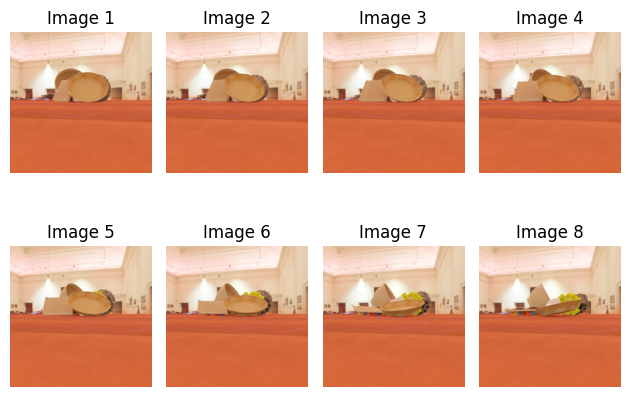

In [26]:
import matplotlib.pyplot as plt
from PIL import Image

images_data = df1['image'].iloc[:8]  # Selecting the first 8 images for example

for i, image_data in enumerate(images_data):
    img = Image.fromarray(image_data)  # Convert the image data to PIL Image format

    # Plot the image without bounding boxes
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f'Image {i+1}')
    plt.axis('off')


plt.tight_layout()
plt.show()


# Creating a dataframe for the second video

In [10]:
df2 = process_videos(second_video)

In [11]:
df2['image_name'] = 'linear_' + df2['image_name']

In [12]:
df2

image  \
0    [[[97, 88, 91], [97, 87, 91], [96, 86, 90], [9...   
1    [[[98, 89, 94], [95, 87, 91], [95, 86, 90], [9...   
2    [[[96, 87, 92], [97, 88, 94], [97, 89, 95], [9...   
3    [[[95, 86, 92], [95, 86, 92], [98, 89, 96], [9...   
4    [[[98, 89, 95], [97, 88, 95], [96, 87, 94], [9...   
..                                                 ...   
715  [[[145, 157, 68], [147, 158, 76], [143, 153, 8...   
716  [[[141, 155, 63], [145, 153, 83], [139, 138, 1...   
717  [[[141, 145, 96], [143, 140, 120], [126, 125, ...   
718  [[[141, 134, 116], [131, 119, 93], [144, 134, ...   
719  [[[135, 116, 95], [154, 141, 132], [161, 144, ...   

                  image_name  \
0     linear_b'0001'_frame_0   
1     linear_b'0001'_frame_1   
2     linear_b'0001'_frame_2   
3     linear_b'0001'_frame_3   
4     linear_b'0001'_frame_4   
..                       ...   
715  linear_b'0000'_frame_19   
716  linear_b'0000'_frame_20   
717  linear_b'0000'_frame_21   
718  linear_b'0000'_frame_22   
719  linear_b'0000'_frame_23   

                                        bounding_boxes  \
0    [[0.412109375, 0.703125, 0.53515625, 0.5859375...   
1    [[0.39453125, 0.69921875, 0.5078125, 0.5546875...   
2    [[0.376953125, 0.693359375, 0.46484375, 0.5273...   
3    [[0.376953125, 0.689453125, 0.42578125, 0.5039...   
4    [[0.40625, 0.69921875, 0.4296875, 0.5234375], ...   
..                                                 ...   
715  [[0.404296875, 0.23828125, 0.23046875, 0.21875...   
716  [[0.3984375, 0.234375, 0.2109375, 0.21875], [0...   
717  [[0.39453125, 0.23046875, 0.1953125, 0.21875],...   
718  [[0.375, 0.228515625, 0.21875, 0.22265625], [0...   
719  [[0.35546875, 0.22265625, 0.2265625, 0.21875],...   

                       classes  
0    [16, 13, 6, 6, 16, 6, 13]  
1    [16, 13, 6, 6, 16, 6, 13]  
2    [16, 13, 6, 6, 16, 6, 13]  
3    [16, 13, 6, 6, 16, 6, 13]  
4    [16, 13, 6, 6, 16, 6, 13]  
..                         ...  
715     [13, 3, 14, 14, 13, 6]  
716     [13, 3, 14, 14, 13, 6]  
717     [13, 3, 14, 14, 13, 6]  
718      [13, 3, 6, 14, 13, 6]  
719         [13, 3, 14, 13, 6]  

[720 rows x 4 columns]

plotting some images as example for linear video 

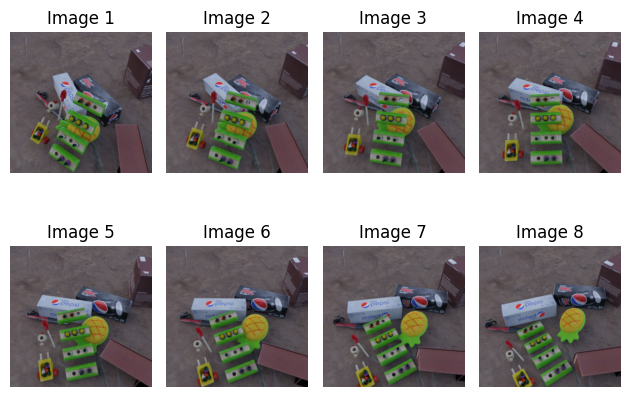

In [27]:
import matplotlib.pyplot as plt
from PIL import Image



images_data = df2['image'].iloc[:8]  # Selecting the first 4 images for example

for i, image_data in enumerate(images_data):
    img = Image.fromarray(image_data)  # Convert the image data to PIL Image format

    # Plot the image without bounding boxes
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f'Image {i+1}')
    plt.axis('off')


plt.tight_layout()
plt.show()


# Creating a dataframe for the third video

In [13]:
df3 = process_videos(third_video)

In [14]:
df3['image_name'] = 'rotated_' + df3['image_name']

In [15]:
df3

image  \
0    [[[211, 193, 133], [211, 193, 133], [211, 193,...   
1    [[[208, 188, 126], [208, 188, 127], [208, 189,...   
2    [[[217, 200, 146], [215, 197, 142], [214, 195,...   
3    [[[224, 210, 167], [223, 210, 166], [223, 209,...   
4    [[[224, 210, 166], [223, 210, 166], [224, 210,...   
..                                                 ...   
715  [[[180, 75, 46], [174, 73, 47], [165, 68, 43],...   
716  [[[194, 87, 54], [193, 86, 54], [193, 84, 53],...   
717  [[[194, 89, 51], [194, 89, 51], [194, 89, 51],...   
718  [[[188, 84, 49], [188, 85, 49], [191, 87, 51],...   
719  [[[193, 88, 53], [191, 87, 51], [192, 88, 52],...   

                   image_name  \
0     rotated_b'0005'_frame_0   
1     rotated_b'0005'_frame_1   
2     rotated_b'0005'_frame_2   
3     rotated_b'0005'_frame_3   
4     rotated_b'0005'_frame_4   
..                        ...   
715  rotated_b'0008'_frame_19   
716  rotated_b'0008'_frame_20   
717  rotated_b'0008'_frame_21   
718  rotated_b'0008'_frame_22   
719  rotated_b'0008'_frame_23   

                                        bounding_boxes  \
0    [[0.486328125, 0.287109375, 0.30078125, 0.2148...   
1    [[0.4921875, 0.2890625, 0.3203125, 0.21875], [...   
2    [[0.5, 0.291015625, 0.3359375, 0.22265625], [0...   
3    [[0.51171875, 0.294921875, 0.3515625, 0.222656...   
4    [[0.5234375, 0.310546875, 0.3515625, 0.2148437...   
..                                                 ...   
715  [[0.455078125, 0.458984375, 0.23046875, 0.2304...   
716  [[0.4609375, 0.45703125, 0.1875, 0.2265625], [...   
717  [[0.466796875, 0.455078125, 0.13671875, 0.2148...   
718  [[0.48046875, 0.453125, 0.15625, 0.21875], [0....   
719  [[0.486328125, 0.44921875, 0.19921875, 0.22656...   

                      classes  
0    [13, 6, 6, 13, 13, 0, 6]  
1    [13, 6, 6, 13, 13, 0, 6]  
2    [13, 6, 6, 13, 13, 0, 6]  
3    [13, 6, 6, 13, 13, 0, 6]  
4    [13, 6, 6, 13, 13, 0, 6]  
..                        ...  
715               [6, 16, 13]  
716               [6, 16, 13]  
717               [6, 16, 13]  
718               [6, 16, 13]  
719               [6, 16, 13]  

[720 rows x 4 columns]

plotting some images as example for rotated video 

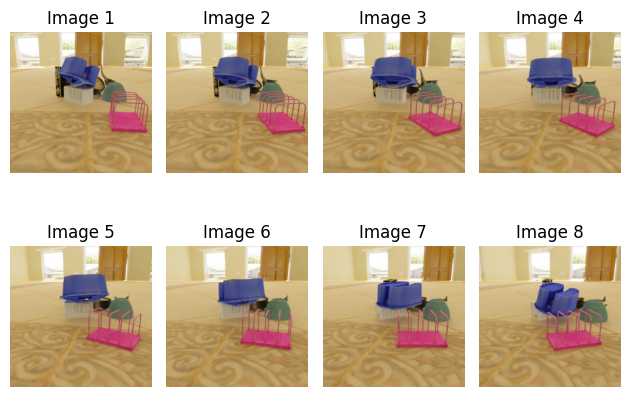

In [28]:
import matplotlib.pyplot as plt
from PIL import Image


images_data = df3['image'].iloc[:8]  # Selecting the first 8 images for example

for i, image_data in enumerate(images_data):
    img = Image.fromarray(image_data)  # Convert the image data to PIL Image format

    # Plot the image without bounding boxes
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f'Image {i+1}')
    plt.axis('off')


plt.tight_layout()
plt.show()


# Gathering all three dataframes together 

In [16]:
df = pd.concat([df1, df2, df3], ignore_index=True)

In [17]:
df

image  \
0     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
1     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
2     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
3     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
4     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
...                                                 ...   
2155  [[[180, 75, 46], [174, 73, 47], [165, 68, 43],...   
2156  [[[194, 87, 54], [193, 86, 54], [193, 84, 53],...   
2157  [[[194, 89, 51], [194, 89, 51], [194, 89, 51],...   
2158  [[[188, 84, 49], [188, 85, 49], [191, 87, 51],...   
2159  [[[193, 88, 53], [191, 87, 51], [192, 88, 52],...   

                    image_name  \
0        fixed_b'0003'_frame_0   
1        fixed_b'0003'_frame_1   
2        fixed_b'0003'_frame_2   
3        fixed_b'0003'_frame_3   
4        fixed_b'0003'_frame_4   
...                        ...   
2155  rotated_b'0008'_frame_19   
2156  rotated_b'0008'_frame_20   
2157  rotated_b'0008'_frame_21   
2158  rotated_b'0008'_frame_22   
2159  rotated_b'0008'_frame_23   

                                         bounding_boxes  \
0     [[0.548828125, 0.396484375, 0.29296875, 0.2148...   
1     [[0.55078125, 0.3984375, 0.2890625, 0.203125],...   
2     [[0.552734375, 0.40234375, 0.29296875, 0.20312...   
3     [[0.5546875, 0.40625, 0.296875, 0.1953125], [0...   
4     [[0.556640625, 0.4140625, 0.30859375, 0.179687...   
...                                                 ...   
2155  [[0.455078125, 0.458984375, 0.23046875, 0.2304...   
2156  [[0.4609375, 0.45703125, 0.1875, 0.2265625], [...   
2157  [[0.466796875, 0.455078125, 0.13671875, 0.2148...   
2158  [[0.48046875, 0.453125, 0.15625, 0.21875], [0....   
2159  [[0.486328125, 0.44921875, 0.19921875, 0.22656...   

                         classes  
0         [13, 6, 16, 13, 14, 3]  
1         [13, 6, 16, 13, 14, 3]  
2     [13, 6, 16, 13, 10, 14, 3]  
3     [13, 6, 16, 13, 10, 14, 3]  
4     [13, 6, 16, 13, 10, 14, 3]  
...                          ...  
2155                 [6, 16, 13]  
2156                 [6, 16, 13]  
2157                 [6, 16, 13]  
2158                 [6, 16, 13]  
2159                 [6, 16, 13]  

[2160 rows x 4 columns]

 creating a new column in the DataFrame named "class_box". It does this by combining the "classes" and "bounding_boxes" columns element-wise for each row using the zip() function. The apply() method with lambda is used to iterate through each row of the DataFrame. For each row, it zips the values in the "classes" and "bounding_boxes" columns together and stores them as a list in the new "class_box" column.

In [29]:
# create a new column by zipping the classes and bounding_boxes columns
df["class_box"] = df.apply(lambda row: list(zip(row.classes, row.bounding_boxes)), axis=1)

# print the dataframe with the new column
print(df)

                                                  image  \
0     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
1     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
2     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
3     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
4     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
...                                                 ...   
2155  [[[180, 75, 46], [174, 73, 47], [165, 68, 43],...   
2156  [[[194, 87, 54], [193, 86, 54], [193, 84, 53],...   
2157  [[[194, 89, 51], [194, 89, 51], [194, 89, 51],...   
2158  [[[188, 84, 49], [188, 85, 49], [191, 87, 51],...   
2159  [[[193, 88, 53], [191, 87, 51], [192, 88, 52],...   

                    image_name  \
0        fixed_b'0003'_frame_0   
1        fixed_b'0003'_frame_1   
2        fixed_b'0003'_frame_2   
3        fixed_b'0003'_frame_3   
4        fixed_b'0003'_frame_4   
...                        ...   
2155  rotated_b'0008'_frame_19   
2156  rotated_b'000

In [30]:
df

image  \
0     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
1     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
2     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
3     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
4     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
...                                                 ...   
2155  [[[180, 75, 46], [174, 73, 47], [165, 68, 43],...   
2156  [[[194, 87, 54], [193, 86, 54], [193, 84, 53],...   
2157  [[[194, 89, 51], [194, 89, 51], [194, 89, 51],...   
2158  [[[188, 84, 49], [188, 85, 49], [191, 87, 51],...   
2159  [[[193, 88, 53], [191, 87, 51], [192, 88, 52],...   

                    image_name  \
0        fixed_b'0003'_frame_0   
1        fixed_b'0003'_frame_1   
2        fixed_b'0003'_frame_2   
3        fixed_b'0003'_frame_3   
4        fixed_b'0003'_frame_4   
...                        ...   
2155  rotated_b'0008'_frame_19   
2156  rotated_b'0008'_frame_20   
2157  rotated_b'0008'_frame_21   
2158  rotated_b'0008'_frame_22   
2159  rotated_b'0008'_frame_23   

                                         bounding_boxes  \
0     [[0.548828125, 0.396484375, 0.29296875, 0.2148...   
1     [[0.55078125, 0.3984375, 0.2890625, 0.203125],...   
2     [[0.552734375, 0.40234375, 0.29296875, 0.20312...   
3     [[0.5546875, 0.40625, 0.296875, 0.1953125], [0...   
4     [[0.556640625, 0.4140625, 0.30859375, 0.179687...   
...                                                 ...   
2155  [[0.455078125, 0.458984375, 0.23046875, 0.2304...   
2156  [[0.4609375, 0.45703125, 0.1875, 0.2265625], [...   
2157  [[0.466796875, 0.455078125, 0.13671875, 0.2148...   
2158  [[0.48046875, 0.453125, 0.15625, 0.21875], [0....   
2159  [[0.486328125, 0.44921875, 0.19921875, 0.22656...   

                         classes  \
0         [13, 6, 16, 13, 14, 3]   
1         [13, 6, 16, 13, 14, 3]   
2     [13, 6, 16, 13, 10, 14, 3]   
3     [13, 6, 16, 13, 10, 14, 3]   
4     [13, 6, 16, 13, 10, 14, 3]   
...                          ...   
2155                 [6, 16, 13]   
2156                 [6, 16, 13]   
2157                 [6, 16, 13]   
2158                 [6, 16, 13]   
2159                 [6, 16, 13]   

                                              class_box  
0     [(13, [0.548828125, 0.396484375, 0.29296875, 0...  
1     [(13, [0.55078125, 0.3984375, 0.2890625, 0.203...  
2     [(13, [0.552734375, 0.40234375, 0.29296875, 0....  
3     [(13, [0.5546875, 0.40625, 0.296875, 0.1953125...  
4     [(13, [0.556640625, 0.4140625, 0.30859375, 0.1...  
...                                                 ...  
2155  [(6, [0.455078125, 0.458984375, 0.23046875, 0....  
2156  [(6, [0.4609375, 0.45703125, 0.1875, 0.2265625...  
2157  [(6, [0.466796875, 0.455078125, 0.13671875, 0....  
2158  [(6, [0.48046875, 0.453125, 0.15625, 0.21875])...  
2159  [(6, [0.486328125, 0.44921875, 0.19921875, 0.2...  

[2160 rows x 5 columns]

In [31]:
# print the first row values for class_box
print(df["class_box"].iloc[0])

[(13, [0.548828125, 0.396484375, 0.29296875, 0.21484375]), (6, [0.41015625, 0.341796875, 0.1953125, 0.16015625]), (16, [0.3671875, 0.419921875, 0.1328125, 0.16015625]), (13, [0.66015625, 0.400390625, 0.109375, 0.19140625]), (14, [0.435546875, 0.478515625, 0.03515625, 0.03515625]), (3, [0.46875, 0.482421875, 0.0546875, 0.03515625])]


In [32]:
# define a function to check if a list contains class 14
def has_class_14(lst):
    # loop over the list
    for class_, box in lst:
        # if the class is 14, return True
        if class_ == 14:
            return True
    # if no class is 14, return False
    return False

In [33]:
# create a new Boolean column by applying the function to the class_box column
df["has_class_14"] = df["class_box"].apply(has_class_14)

In [34]:
# filter the dataframe by the new column
df_class_14 = df.loc[df["has_class_14"]]
# or
df_class_14 = df[df["has_class_14"]]

In [35]:
# drop the has_class_14 column
df_class_14 = df_class_14.drop("has_class_14", axis=1)

In [36]:
df_class_14

image  \
0     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
1     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
2     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
3     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
4     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
...                                                 ...   
2131  [[[19, 19, 23], [23, 23, 27], [25, 25, 29], [2...   
2132  [[[36, 36, 39], [39, 41, 45], [35, 36, 42], [3...   
2133  [[[76, 66, 63], [93, 82, 72], [100, 92, 89], [...   
2134  [[[90, 99, 81], [84, 88, 62], [93, 100, 83], [...   
2135  [[[74, 101, 78], [100, 119, 99], [97, 121, 110...   

                    image_name  \
0        fixed_b'0003'_frame_0   
1        fixed_b'0003'_frame_1   
2        fixed_b'0003'_frame_2   
3        fixed_b'0003'_frame_3   
4        fixed_b'0003'_frame_4   
...                        ...   
2131  rotated_b'0000'_frame_19   
2132  rotated_b'0000'_frame_20   
2133  rotated_b'0000'_frame_21   
2134  rotated_b'0000'_frame_22   
2135  rotated_b'0000'_frame_23   

                                         bounding_boxes  \
0     [[0.548828125, 0.396484375, 0.29296875, 0.2148...   
1     [[0.55078125, 0.3984375, 0.2890625, 0.203125],...   
2     [[0.552734375, 0.40234375, 0.29296875, 0.20312...   
3     [[0.5546875, 0.40625, 0.296875, 0.1953125], [0...   
4     [[0.556640625, 0.4140625, 0.30859375, 0.179687...   
...                                                 ...   
2131  [[0.587890625, 0.640625, 0.37109375, 0.359375]...   
2132  [[0.53515625, 0.6640625, 0.3984375, 0.3828125]...   
2133  [[0.474609375, 0.68359375, 0.41796875, 0.39843...   
2134  [[0.41015625, 0.701171875, 0.4375, 0.41015625]...   
2135  [[0.345703125, 0.71484375, 0.46484375, 0.42187...   

                          classes  \
0          [13, 6, 16, 13, 14, 3]   
1          [13, 6, 16, 13, 14, 3]   
2      [13, 6, 16, 13, 10, 14, 3]   
3      [13, 6, 16, 13, 10, 14, 3]   
4      [13, 6, 16, 13, 10, 14, 3]   
...                           ...   
2131  [16, 13, 13, 13, 14, 13, 6]   
2132  [16, 13, 13, 13, 14, 13, 6]   
2133      [16, 13, 13, 14, 13, 6]   
2134      [16, 13, 13, 14, 13, 6]   
2135          [16, 13, 14, 13, 6]   

                                              class_box  
0     [(13, [0.548828125, 0.396484375, 0.29296875, 0...  
1     [(13, [0.55078125, 0.3984375, 0.2890625, 0.203...  
2     [(13, [0.552734375, 0.40234375, 0.29296875, 0....  
3     [(13, [0.5546875, 0.40625, 0.296875, 0.1953125...  
4     [(13, [0.556640625, 0.4140625, 0.30859375, 0.1...  
...                                                 ...  
2131  [(16, [0.587890625, 0.640625, 0.37109375, 0.35...  
2132  [(16, [0.53515625, 0.6640625, 0.3984375, 0.382...  
2133  [(16, [0.474609375, 0.68359375, 0.41796875, 0....  
2134  [(16, [0.41015625, 0.701171875, 0.4375, 0.4101...  
2135  [(16, [0.345703125, 0.71484375, 0.46484375, 0....  

[1094 rows x 5 columns]

In [37]:
# define a function to filter a list by class 14
def filter_class_14(lst):
    # create an empty list to store the filtered tuples
    new_lst = []
    # loop over the list
    for class_, box in lst:
        # if the class is 14, append the tuple to the new list
        if class_ == 14:
            new_lst.append((class_, box))
    # return the new list
    return new_lst

In [38]:
# create a new column by applying the function to the class_box column
df_class_14["class_box_14"] = df_class_14["class_box"].apply(filter_class_14)
# or
# overwrite the existing column by applying the function to the class_box column
df_class_14["class_box"] = df_class_14["class_box"].apply(filter_class_14)

In [39]:
# drop the original class_box column
df_class_14 = df_class_14.drop("class_box", axis=1)

In [40]:
df_class_14

image  \
0     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
1     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
2     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
3     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
4     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
...                                                 ...   
2131  [[[19, 19, 23], [23, 23, 27], [25, 25, 29], [2...   
2132  [[[36, 36, 39], [39, 41, 45], [35, 36, 42], [3...   
2133  [[[76, 66, 63], [93, 82, 72], [100, 92, 89], [...   
2134  [[[90, 99, 81], [84, 88, 62], [93, 100, 83], [...   
2135  [[[74, 101, 78], [100, 119, 99], [97, 121, 110...   

                    image_name  \
0        fixed_b'0003'_frame_0   
1        fixed_b'0003'_frame_1   
2        fixed_b'0003'_frame_2   
3        fixed_b'0003'_frame_3   
4        fixed_b'0003'_frame_4   
...                        ...   
2131  rotated_b'0000'_frame_19   
2132  rotated_b'0000'_frame_20   
2133  rotated_b'0000'_frame_21   
2134  rotated_b'0000'_frame_22   
2135  rotated_b'0000'_frame_23   

                                         bounding_boxes  \
0     [[0.548828125, 0.396484375, 0.29296875, 0.2148...   
1     [[0.55078125, 0.3984375, 0.2890625, 0.203125],...   
2     [[0.552734375, 0.40234375, 0.29296875, 0.20312...   
3     [[0.5546875, 0.40625, 0.296875, 0.1953125], [0...   
4     [[0.556640625, 0.4140625, 0.30859375, 0.179687...   
...                                                 ...   
2131  [[0.587890625, 0.640625, 0.37109375, 0.359375]...   
2132  [[0.53515625, 0.6640625, 0.3984375, 0.3828125]...   
2133  [[0.474609375, 0.68359375, 0.41796875, 0.39843...   
2134  [[0.41015625, 0.701171875, 0.4375, 0.41015625]...   
2135  [[0.345703125, 0.71484375, 0.46484375, 0.42187...   

                          classes  \
0          [13, 6, 16, 13, 14, 3]   
1          [13, 6, 16, 13, 14, 3]   
2      [13, 6, 16, 13, 10, 14, 3]   
3      [13, 6, 16, 13, 10, 14, 3]   
4      [13, 6, 16, 13, 10, 14, 3]   
...                           ...   
2131  [16, 13, 13, 13, 14, 13, 6]   
2132  [16, 13, 13, 13, 14, 13, 6]   
2133      [16, 13, 13, 14, 13, 6]   
2134      [16, 13, 13, 14, 13, 6]   
2135          [16, 13, 14, 13, 6]   

                                           class_box_14  
0     [(14, [0.435546875, 0.478515625, 0.03515625, 0...  
1     [(14, [0.45703125, 0.478515625, 0.0390625, 0.0...  
2     [(14, [0.46484375, 0.478515625, 0.0390625, 0.0...  
3     [(14, [0.466796875, 0.4765625, 0.04296875, 0.0...  
4     [(14, [0.46484375, 0.474609375, 0.046875, 0.04...  
...                                                 ...  
2131  [(14, [0.3984375, 0.513671875, 0.1796875, 0.10...  
2132  [(14, [0.388671875, 0.509765625, 0.18359375, 0...  
2133  [(14, [0.376953125, 0.509765625, 0.19140625, 0...  
2134  [(14, [0.3671875, 0.505859375, 0.1953125, 0.08...  
2135  [(14, [0.357421875, 0.501953125, 0.19921875, 0...  

[1094 rows x 5 columns]

In [41]:
for i, row in enumerate(df_class_14.itertuples(), start=0):
    df_class_14.at[row.Index, 'image_name'] += f'_{i}'  # Adding a unique number from 0 to 1093

checking the number of images that exist in class 14 

In [42]:
unique_image_names = df_class_14['image_name'].nunique()
print("Number of unique image names:", unique_image_names)

Number of unique image names: 1094


In [43]:
df_class_14

image  \
0     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
1     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
2     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
3     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
4     [[[238, 200, 175], [235, 199, 171], [234, 199,...   
...                                                 ...   
2131  [[[19, 19, 23], [23, 23, 27], [25, 25, 29], [2...   
2132  [[[36, 36, 39], [39, 41, 45], [35, 36, 42], [3...   
2133  [[[76, 66, 63], [93, 82, 72], [100, 92, 89], [...   
2134  [[[90, 99, 81], [84, 88, 62], [93, 100, 83], [...   
2135  [[[74, 101, 78], [100, 119, 99], [97, 121, 110...   

                         image_name  \
0           fixed_b'0003'_frame_0_0   
1           fixed_b'0003'_frame_1_1   
2           fixed_b'0003'_frame_2_2   
3           fixed_b'0003'_frame_3_3   
4           fixed_b'0003'_frame_4_4   
...                             ...   
2131  rotated_b'0000'_frame_19_1089   
2132  rotated_b'0000'_frame_20_1090   
2133  rotated_b'0000'_frame_21_1091   
2134  rotated_b'0000'_frame_22_1092   
2135  rotated_b'0000'_frame_23_1093   

                                         bounding_boxes  \
0     [[0.548828125, 0.396484375, 0.29296875, 0.2148...   
1     [[0.55078125, 0.3984375, 0.2890625, 0.203125],...   
2     [[0.552734375, 0.40234375, 0.29296875, 0.20312...   
3     [[0.5546875, 0.40625, 0.296875, 0.1953125], [0...   
4     [[0.556640625, 0.4140625, 0.30859375, 0.179687...   
...                                                 ...   
2131  [[0.587890625, 0.640625, 0.37109375, 0.359375]...   
2132  [[0.53515625, 0.6640625, 0.3984375, 0.3828125]...   
2133  [[0.474609375, 0.68359375, 0.41796875, 0.39843...   
2134  [[0.41015625, 0.701171875, 0.4375, 0.41015625]...   
2135  [[0.345703125, 0.71484375, 0.46484375, 0.42187...   

                          classes  \
0          [13, 6, 16, 13, 14, 3]   
1          [13, 6, 16, 13, 14, 3]   
2      [13, 6, 16, 13, 10, 14, 3]   
3      [13, 6, 16, 13, 10, 14, 3]   
4      [13, 6, 16, 13, 10, 14, 3]   
...                           ...   
2131  [16, 13, 13, 13, 14, 13, 6]   
2132  [16, 13, 13, 13, 14, 13, 6]   
2133      [16, 13, 13, 14, 13, 6]   
2134      [16, 13, 13, 14, 13, 6]   
2135          [16, 13, 14, 13, 6]   

                                           class_box_14  
0     [(14, [0.435546875, 0.478515625, 0.03515625, 0...  
1     [(14, [0.45703125, 0.478515625, 0.0390625, 0.0...  
2     [(14, [0.46484375, 0.478515625, 0.0390625, 0.0...  
3     [(14, [0.466796875, 0.4765625, 0.04296875, 0.0...  
4     [(14, [0.46484375, 0.474609375, 0.046875, 0.04...  
...                                                 ...  
2131  [(14, [0.3984375, 0.513671875, 0.1796875, 0.10...  
2132  [(14, [0.388671875, 0.509765625, 0.18359375, 0...  
2133  [(14, [0.376953125, 0.509765625, 0.19140625, 0...  
2134  [(14, [0.3671875, 0.505859375, 0.1953125, 0.08...  
2135  [(14, [0.357421875, 0.501953125, 0.19921875, 0...  

[1094 rows x 5 columns]

This function iterates through a DataFrame (df_class_14) containing image data and names, saving the images as JPEG files in a specified directory (save_dir) using OpenCV (cv2.imwrite). The counter saved_images tracks the number of images saved.

In [44]:

# Directory to save images
save_dir = "C:/Users/project/Downloads/final YOLO v8/images"


# Counter to track saved images
saved_images = 0

# Iterate over the DataFrame using 'iterrows'
for index, row in df_class_14.iterrows():
    image = row['image']
    image_name = row['image_name']

    # Construct the path to save the image
    save_path = os.path.join(save_dir, f"{image_name}.jpg")

    # Save the image using OpenCV
    cv2.imwrite(save_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

    saved_images += 1

# Display total saved images
print(f"Total images saved: {saved_images}")

Total images saved: 1094


This function iterates through a DataFrame (df_class_14) containing image names and corresponding class and bounding box details. For each row in the DataFrame, it creates a text file in a specified directory (train_directory) using the image name as the file name. Within each text file, it writes the class and bounding box details provided in the class_bbox_details column, formatting them appropriately for YOLO-style annotations.

In [48]:
import os

train_directory = r'C:/Users/project/Downloads/final YOLO v8/labels'

# Ensure the directory exists, if not, create it
if not os.path.exists(train_directory):
    os.makedirs(train_directory)

for index, row in df_class_14.iterrows():
    image_name = row['image_name']  # Replace with your actual column name containing image names
    class_bbox_details = row['class_box_14']  # Replace with your actual column name for class and bbox details

    # Create a text file with the image name and write class and bbox details into it
    with open(os.path.join(train_directory, f"{image_name}.txt"), 'w') as file:
        for pair in class_bbox_details:
            file.write(' '.join(str(value) for value in pair) + '\n')

print("Text files created for each image in train directory:", train_directory)


Text files created for each image in train directory: C:/Users/project/Downloads/final YOLO v8/labels


the next two function to edit the text annotation files 
The first function iterates through text files in a specified directory, reads their content, and modifies lines that start with the number '14' by replacing it with '0'. This function essentially performs a find-and-replace operation to modify specific lines within the text files.

The second function operates similarly by iterating through text files in a directory. However, it strips leading/trailing whitespaces, removes square brackets ('[' and ']'), and eliminates commas from each line within the text files. This process appears to be preparing the annotation data within the text files, potentially for compatibility or formatting purposes in a specific application or model.

In [49]:

directory = "C:/Users/project/Downloads/final YOLO v8/labels"

# Iterate through each file in the directory
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)

    # Read the file content
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Modify lines that start with '14' and rewrite the file
    with open(file_path, 'w') as file:
        for line in lines:
            if line.startswith('14'):
                # Replace '14' with '0'
                line = line.replace('14', '0')
            file.write(line)

In [50]:
import os

directory = "C:/Users/project/Downloads/final YOLO v8/labels"

for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    if filename.endswith(".txt"):
        with open(filepath, 'r') as file:
            lines = file.readlines()
        
        # Modify each line and rewrite to the file
        with open(filepath, 'w') as file:
            for line in lines:
                line = line.strip()  # Remove leading/trailing whitespaces
                line = line.replace('[', '').replace(']', '')  # Remove square brackets
                line = line.replace(',', '')  # Remove commas
                file.write(line + '\n')  # Rewrite the modified line

# Modeling 

### Now we apply YOLO V8 for object detection, Ultralytics YOLOv8 is a cutting-edge, state-of-the-art (SOTA) model that builds upon the success of previous YOLO versions and introduces new features and improvements to further boost performance and flexibility. YOLOv8 is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection and tracking, instance segmentation, image classification and pose estimation tasks.

In [51]:
!pip install ultralytics

sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1b9cf1992e8>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1b7983eddd8>
C:\Users\project\anaconda3\envs\ML\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedWriter name=5>
  return process_handler(cmd, _system_body)
C:\Users\project\anaconda3\envs\ML\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  return process_handler(cmd, _system_body)
C:\Users\project\anaconda3\envs\ML\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedReader name=7>
  return process_handler(cmd, _system_body)


In [52]:
from ultralytics import YOLO

### The model architecture 

In [53]:
model = YOLO("yolov8n.yaml")  # build a new model from scratch


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

### Train our model 

In [54]:
model.train(data="C:/Users/project/Downloads/final YOLO v8/config.yaml", epochs=100)

New https://pypi.org/project/ultralytics/8.0.218 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.145  Python-3.7.16 torch-1.13.1+cpu CPU (Intel Core(TM) i7-10700 2.90GHz)
WARNING  Upgrade to torch>=2.0.0 for deterministic training.
engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=C:/Users/project/Downloads/final YOLO v8/config.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid

# Results

### We got quite good results after applying Yolo v8

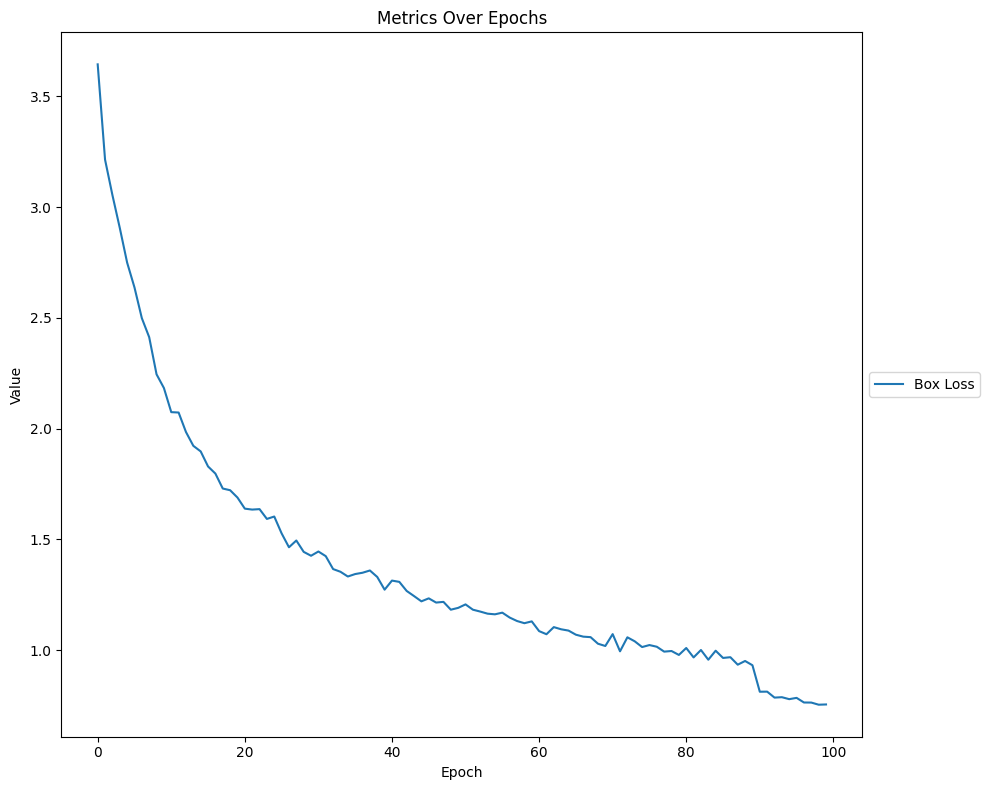

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
file_path = r'C:/Users/project/Downloads/runs/detect/train8/results.csv'
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()
# Plotting
plt.figure(figsize=(10, 8))
sns.lineplot(x='epoch', y='train/box_loss', data=df, label='Box Loss')  # Set label for this line
plt.title('Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # To adjust the legend position
plt.tight_layout()
plt.show()


In [56]:
# Check column names in the DataFrame
print(df.columns)


Index(['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


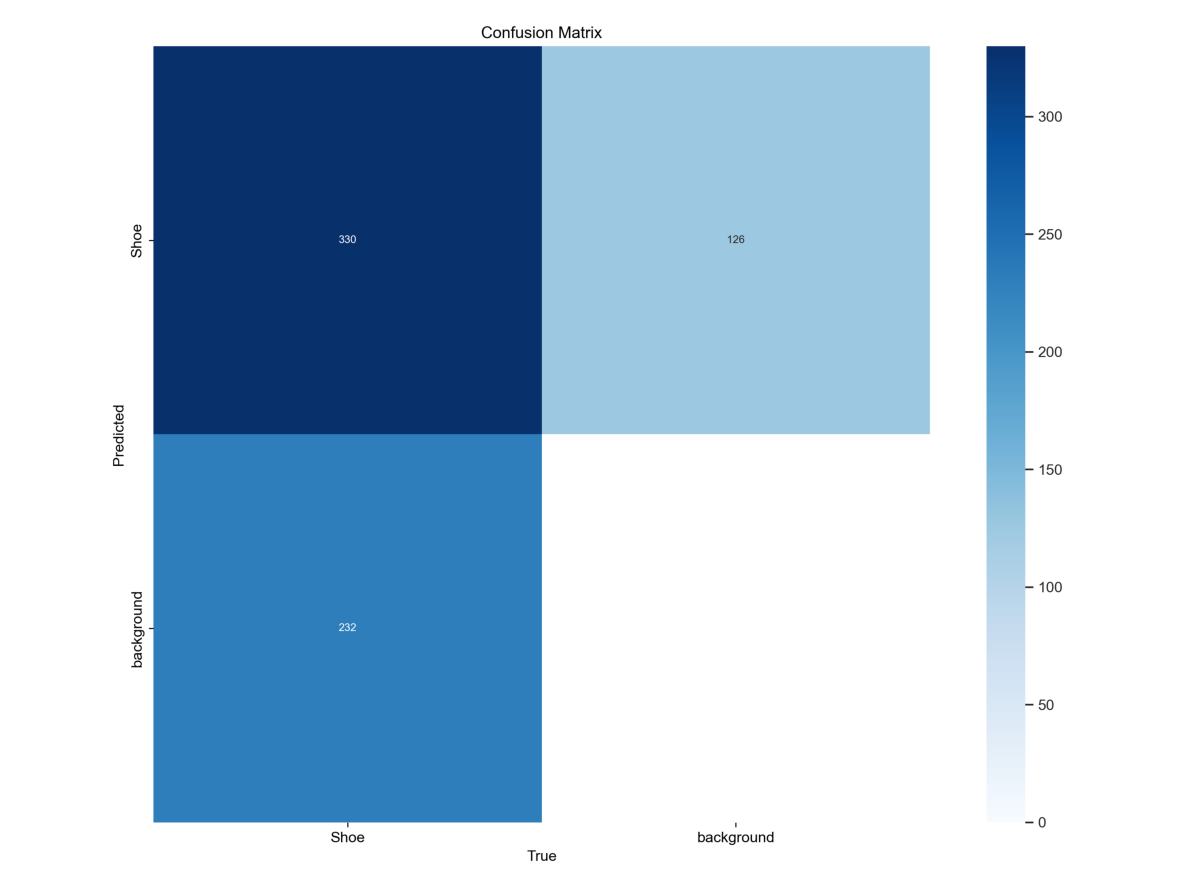

In [57]:
import matplotlib.image as mpimg
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('C:/Users/project/Downloads/runs/detect/train8/confusion_matrix.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off')

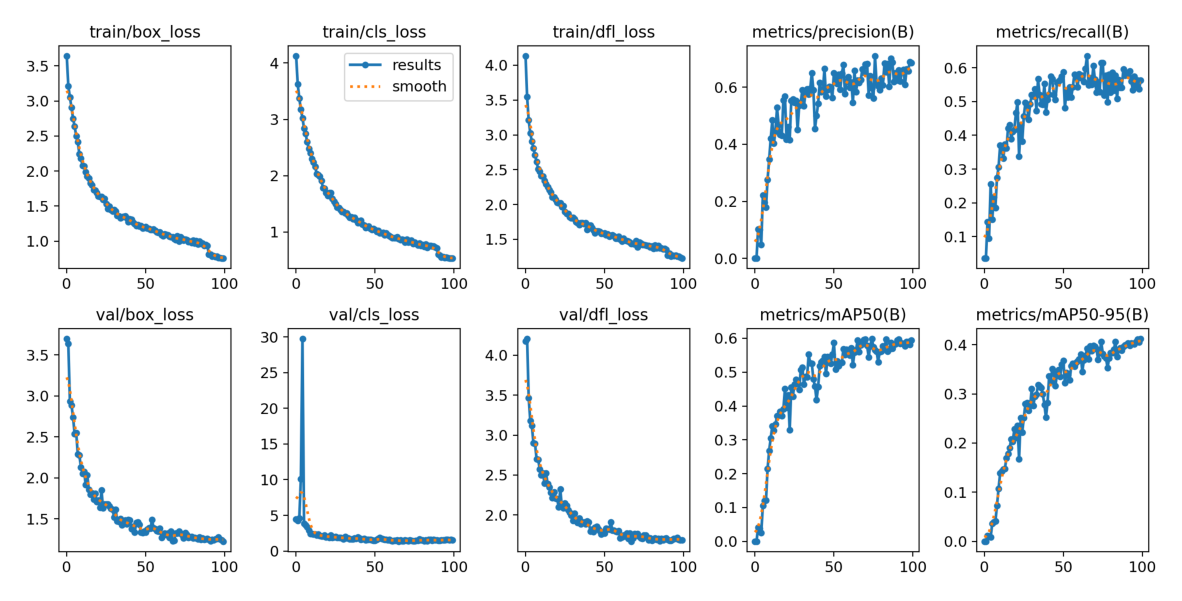

In [58]:
import matplotlib.image as mpimg
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('C:/Users/project/Downloads/runs/detect/train8/results.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off')

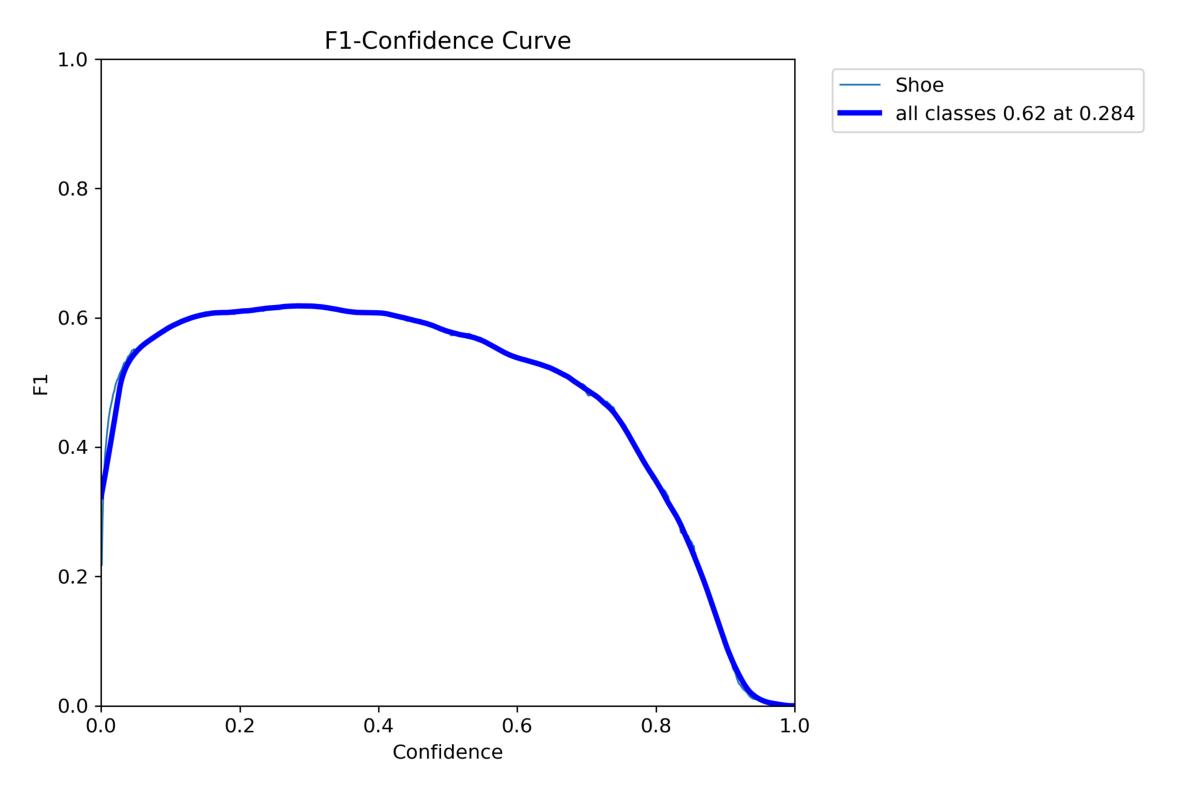

In [59]:
import matplotlib.image as mpimg
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('C:/Users/project/Downloads/runs/detect/train8/F1_curve.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off')

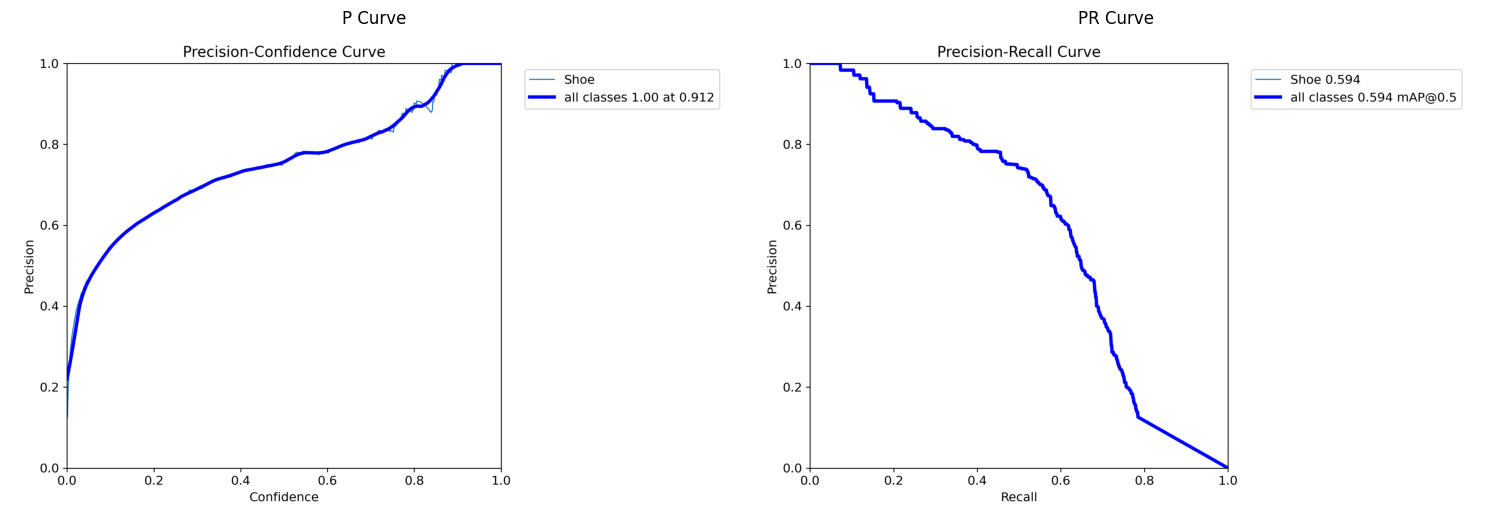

In [60]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Reading the first image
img1 = mpimg.imread('C:/Users/project/Downloads/runs/detect/train8/P_curve.png')

# Reading the second image
img2 = mpimg.imread('C:/Users/project/Downloads/runs/detect/train8/PR_curve.png')

# Plotting both images side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 15))

axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('P Curve')  # Title for the first image

axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('PR Curve')  # Title for the second image

plt.tight_layout()
plt.show()


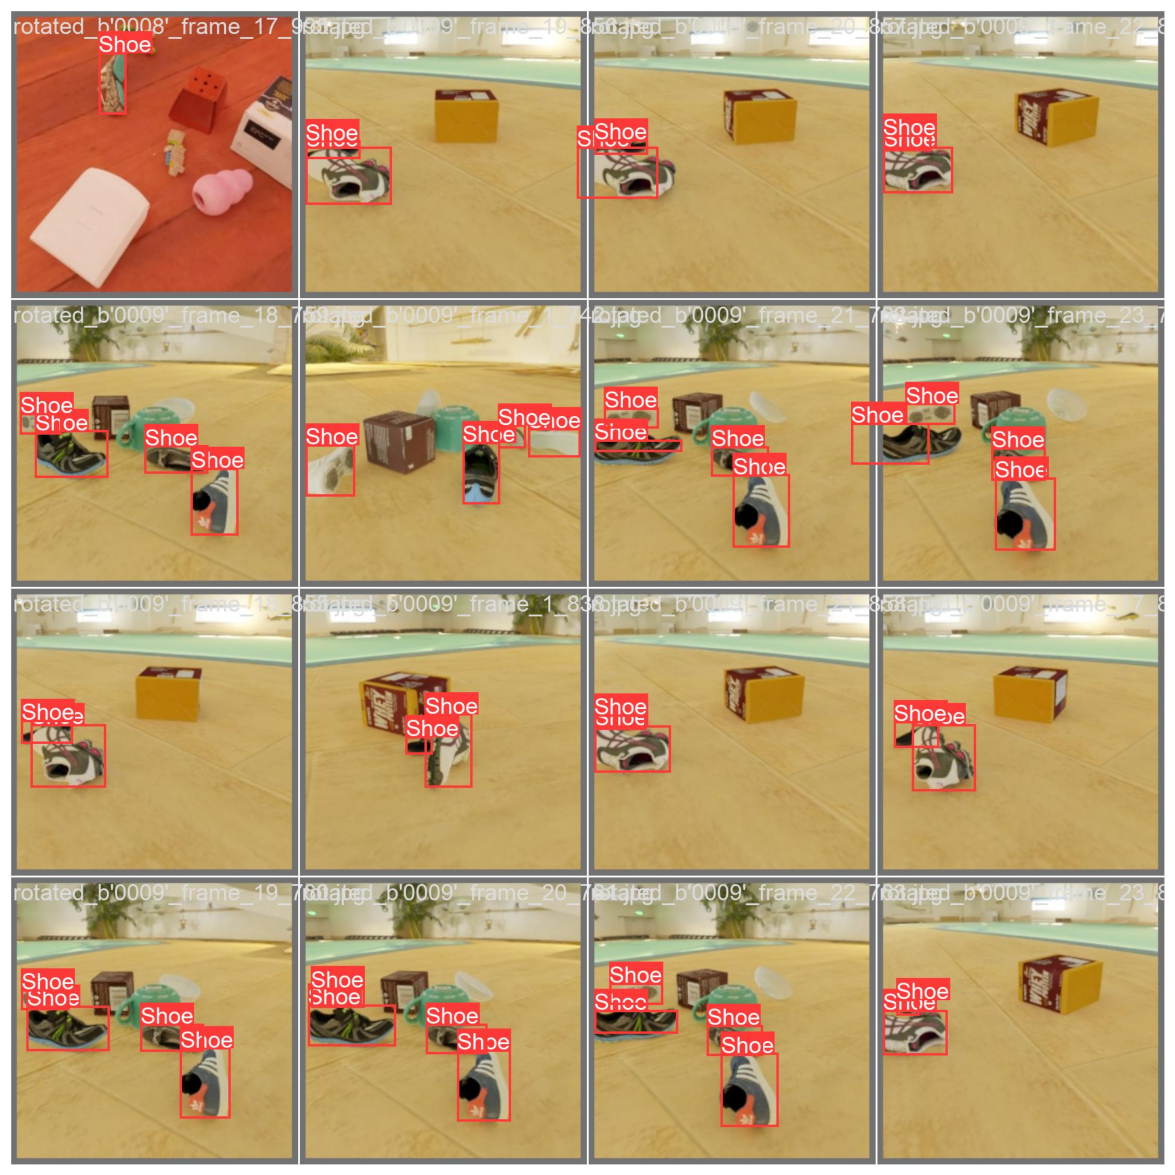

In [61]:
import matplotlib.image as mpimg
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('C:/Users/project/Downloads/runs/detect/train8/val_batch2_labels.jpg')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off')

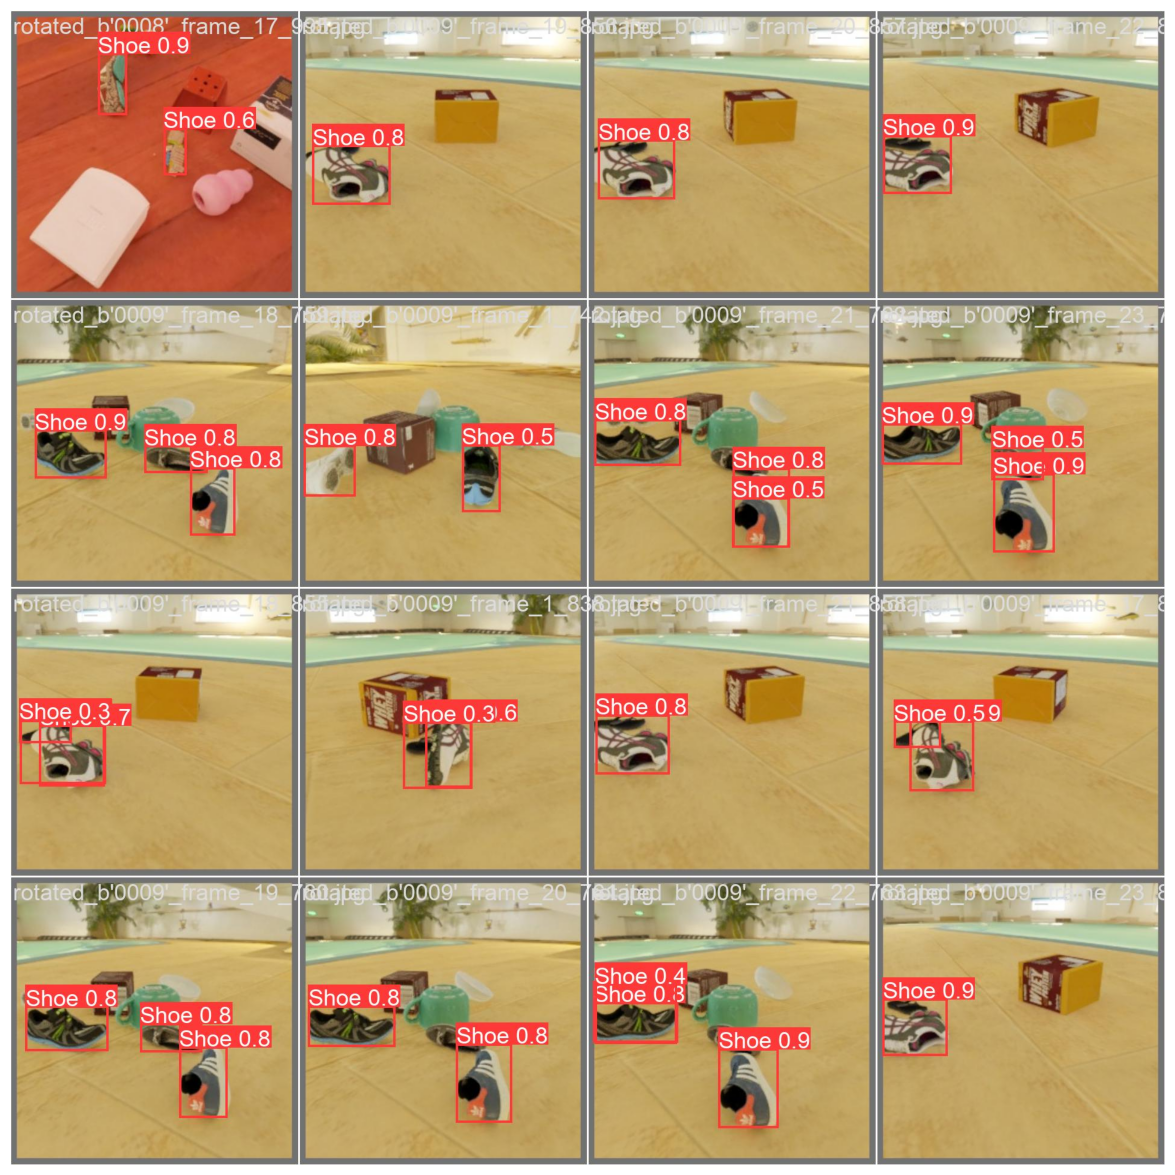

In [62]:
import matplotlib.image as mpimg
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('C:/Users/project/Downloads/runs/detect/train8/val_batch2_pred.jpg')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off')

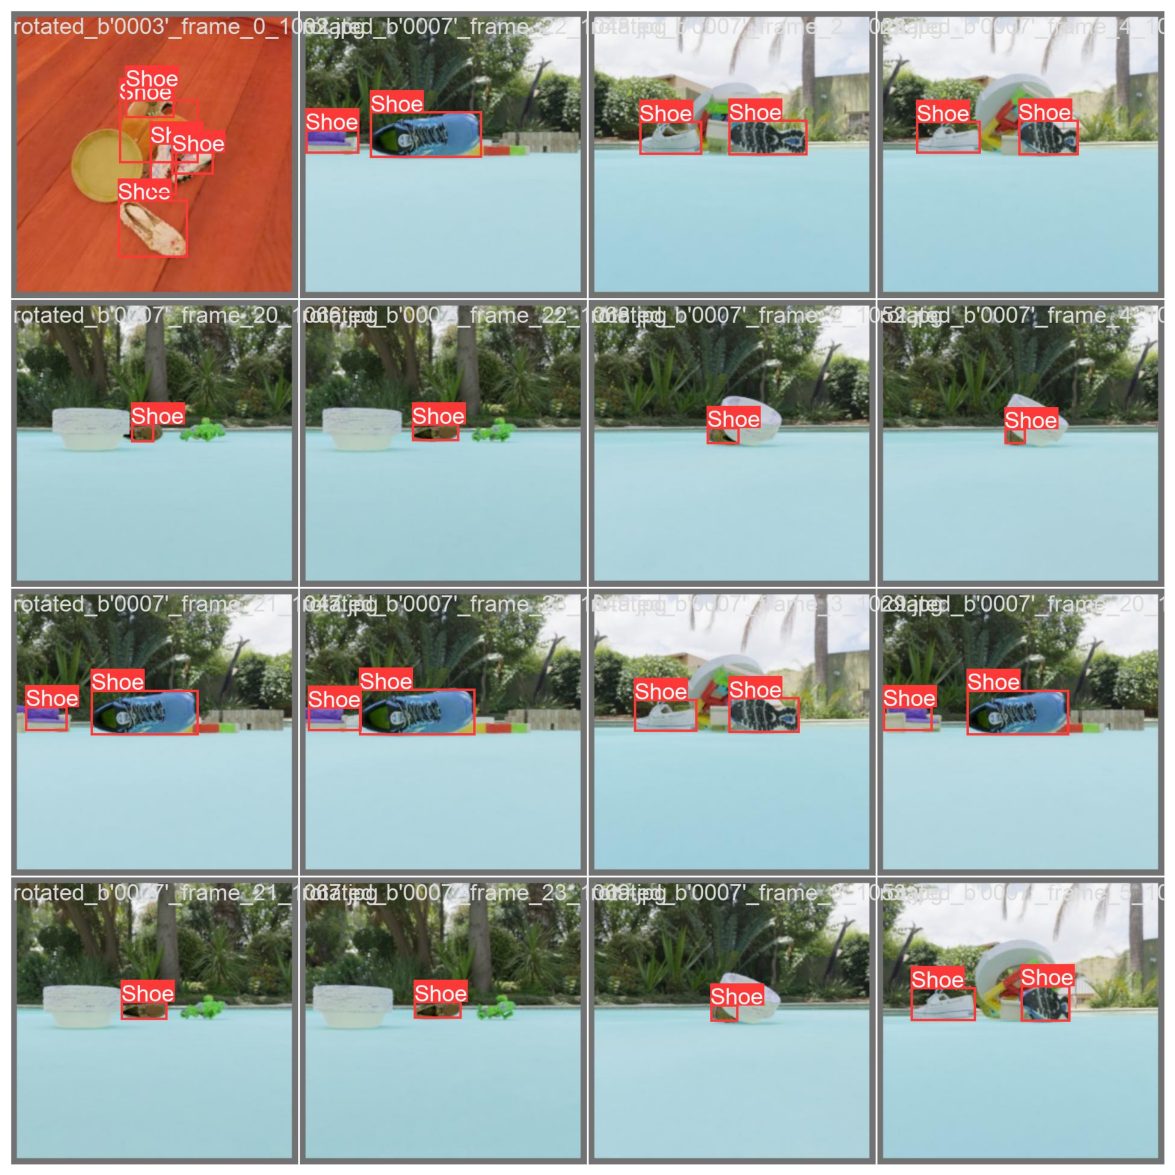

In [63]:
import matplotlib.image as mpimg
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('C:/Users/project/Downloads/runs/detect/train8/val_batch0_labels.jpg')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off');

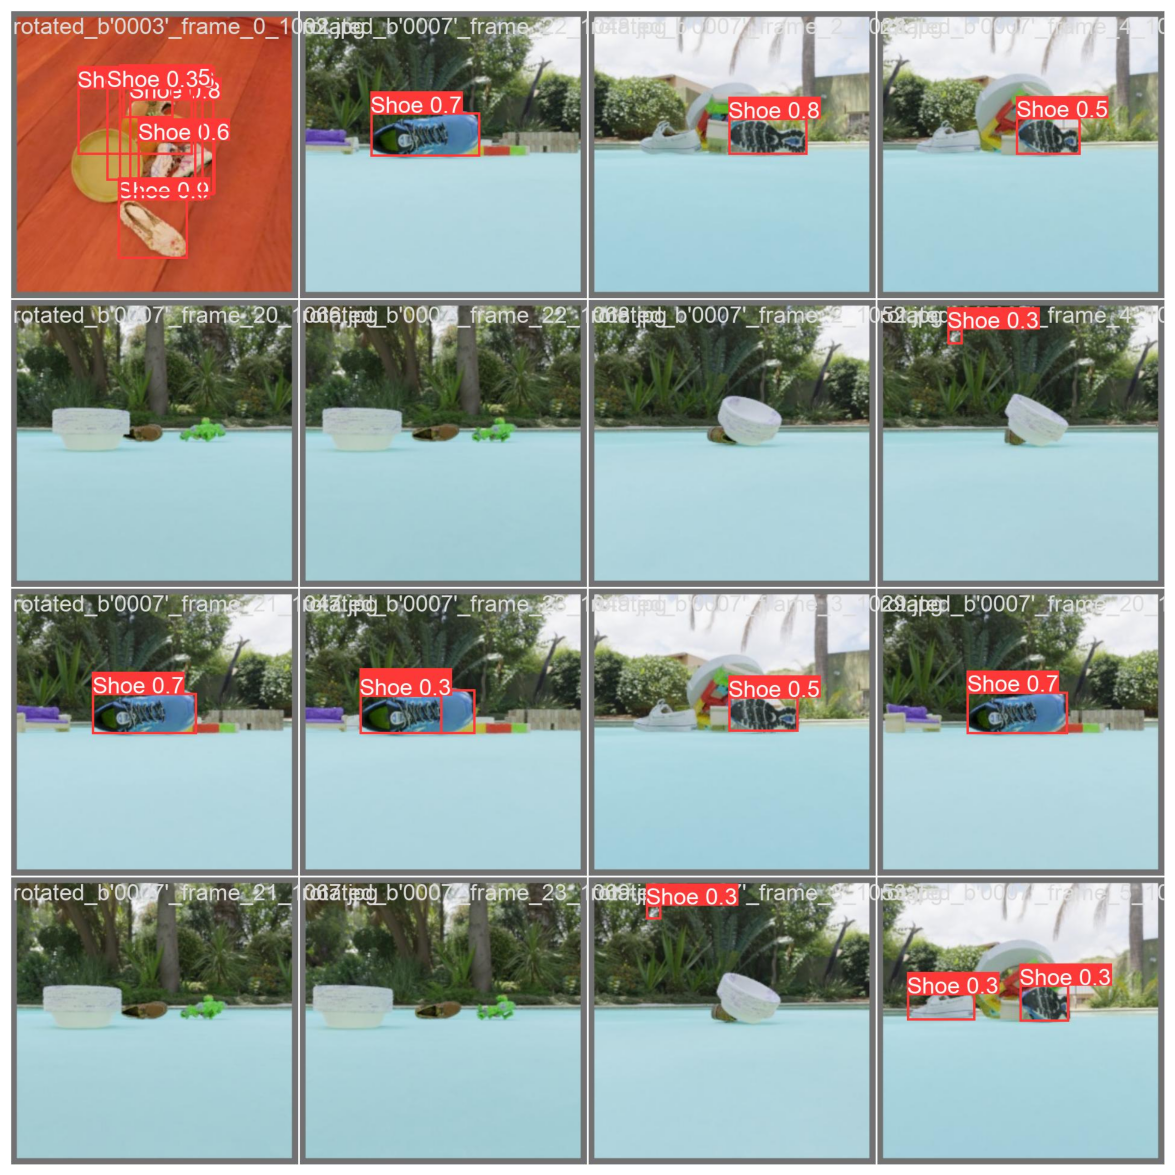

In [64]:
import matplotlib.image as mpimg
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('C:/Users/project/Downloads/runs/detect/train8/val_batch0_pred.jpg')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off');